# Testing the waveforms and scaling

## Imports

In [2]:
import numpy as np
import numpy.typing as npt
import math
import matplotlib.pyplot as plt 
from examples.seismic import Receiver, WaveletSource, RickerSource, Model, TimeAxis,  plot_velocity, plot_shotrecord
from devito import TimeFunction, Eq, solve, Operator, ConditionalDimension
from scipy.signal import find_peaks, peak_prominences

plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size

## Model parameters

In [3]:
nx = 601
nz = 301
nb = 10
shape = (nx, nz)
spacing = (.0001, .0001) #60x30 cm
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
glass = 5
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water 
v[:, -glass:] = v_glass
v[:glass, :] = v_glass
v[-glass:, :] = v_glass

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .02  # Simulation lasts tn milliseconds
dt = model.critical_dt # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


### Source object and position function

In [4]:
class SineSource(WaveletSource):
    @property
    def wavelet(self):
        t0 = self.t0 or 1 / self.f0
        a = self.a or 1
        r = (np.pi * self.f0 * (self.time_values - t0))
        wave = a * np.sin(r) + a*np.sin(3*(r+np.pi)/4)
        wave[np.searchsorted(self.time_values, 4*2/self.f0):] = 0
        return wave

def srcPositions(cx: float, cy:float, alpha:float, ns:int, sdist:float) -> np.typing.NDArray:
    assert alpha >= 0 and alpha < 180
    assert ns > 0
    dx = sdist * math.sin(math.pi / 180 * alpha)
    dy = sdist * math.cos(math.pi / 180 * alpha)

    res = np.zeros((ns, 2))
    res[:, 0] = np.linspace(cx - dx * (ns - 1) / 2, cx + dx * (ns - 1) / 2, num = ns)
    res[:, 1] = np.linspace(cy - dy * (ns - 1) / 2, cy + dy * (ns - 1) / 2, num = ns)
    return res


def setup_beam(src, rec, u, source_distance, center_pos, alpha, dt, c):
    ns = src.coordinates.data.shape[0]
    for i in range(ns):
        src.coordinates.data[i, :] = np.array(
            center_pos[0] + (i - (ns - 1) / 2) * source_distance
        )
    src.coordinates.data[:, -1] = center_pos[1]
#    rec.coordinates.data[:] = src.coordinates.data[:]
    for i in range(ns):
        latency = -np.cos(np.deg2rad(alpha)) * (i * source_distance / c)
        src.data[:, i] = np.roll(src.data[:, i], int(latency / dt) + 300)
    u.data.fill(0)

### Plane wave

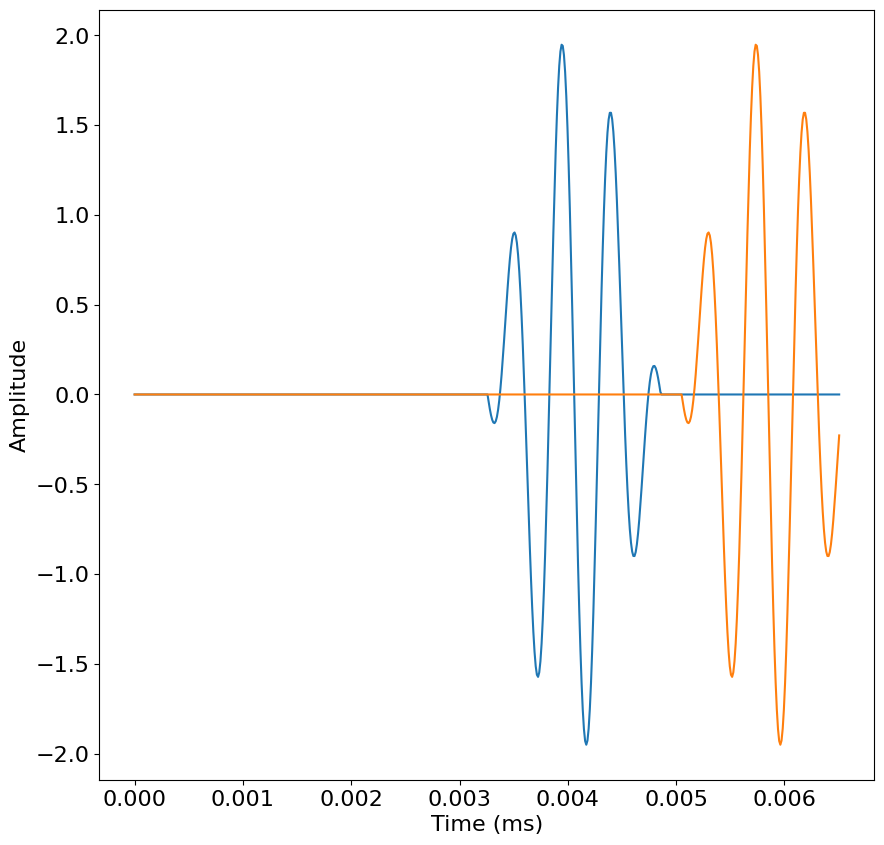

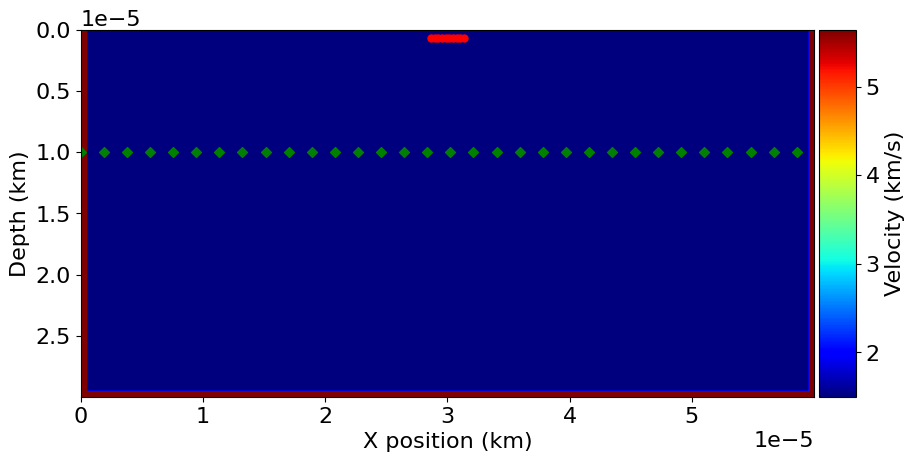

Operator `Kernel` ran in 0.68 s


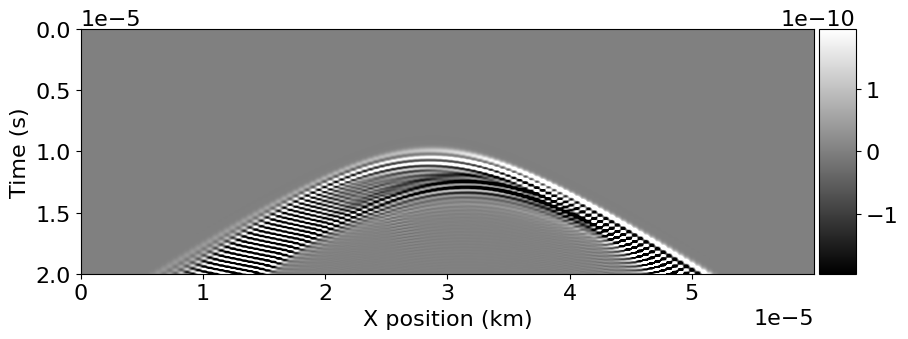

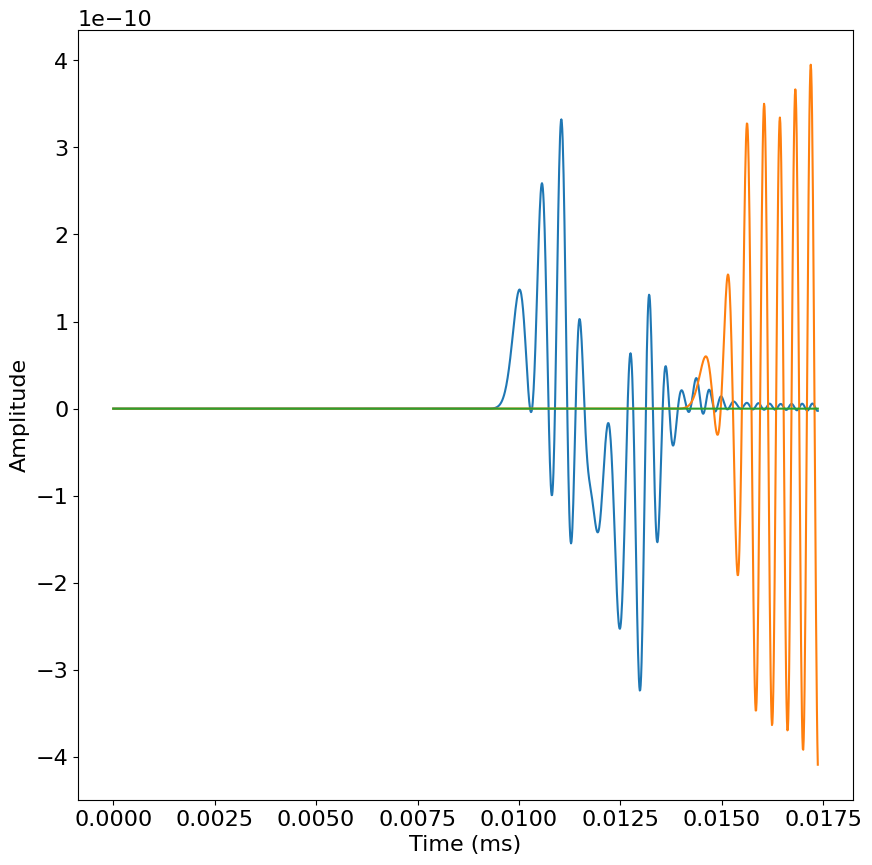

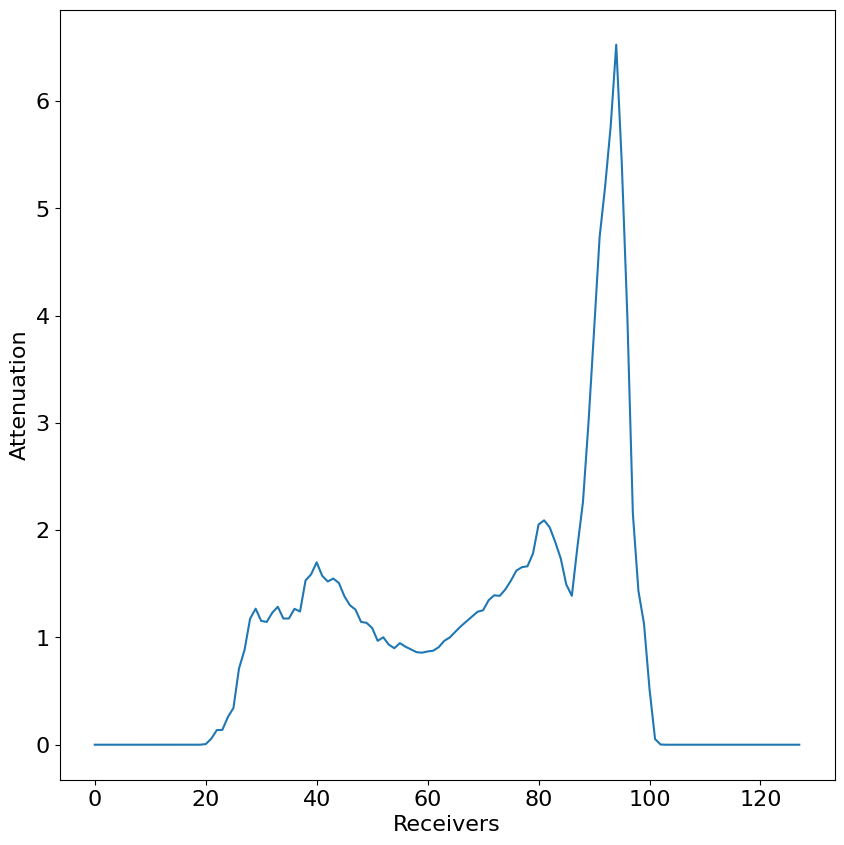

In [25]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 10; # number of sources
nr = 128; # number of receivers
depth = .0005
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = wavelength
alpha = 180 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
center_pos = np.array((cx,cy))
src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)
rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .01
u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
setup_beam(src, rec, u, source_distance, center_pos, alpha, model.critical_dt, v_water)

# src.show()
plt.figure()
plt.plot(src.time_values[0:600], src.data[:600,0])
plt.plot(src.time_values[0:600], src.data[:600,9])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()


plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

cut = 1600

plt.figure()
plt.plot(src.time_values[:cut],rec.data[:cut,64])
plt.plot(src.time_values[:cut],rec.data[:cut,32])
plt.plot(src.time_values[:cut],rec.data[:cut,1])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plt.figure()
plt.plot(np.max(np.abs(rec.data[0:cut,:]), axis=0)/np.max(rec.data[0:cut,int(nr/2)]))
plt.xlabel('Receivers')
plt.ylabel('Attenuation')
plt.tick_params()
plt.show()

In [19]:
import matplotlib.animation as animation

def plot_snapshot_and_signal(snap: npt.NDArray, model,
                             outfile):
    fig = plt.figure(figsize=(12, 8))
    extent = [
        model.origin[0],
        model.origin[0] + model.domain_size[0],
        model.origin[1] + model.domain_size[1],
        model.origin[1],
    ]    
    plt.imshow(
        np.transpose(model.vp.data),
        cmap='viridis',
        vmin=np.min(model.vp.data),
        vmax=np.max(model.vp.data),
        extent=extent,
    )

    ampl_limit = max(abs(np.min(snap)), abs(np.max(snap)))

    matrice = plt.imshow(snap[0, :, :].T,
                            vmin=-ampl_limit,
                            vmax=ampl_limit,
                            alpha=.6,
                            extent=extent,
                            cmap="seismic")
 
    fig.tight_layout()

    def update(i):
        matrice.set_array(snap[i, :, :].T)

        return matrice,

    # Animation
    ani = animation.FuncAnimation(fig,
                                  func=update,
                                  frames=snap.shape[0],
                                  interval=75,
                                  blit=True)
    ani.save(outfile)

factor is 14


Operator `Kernel` ran in 0.65 s


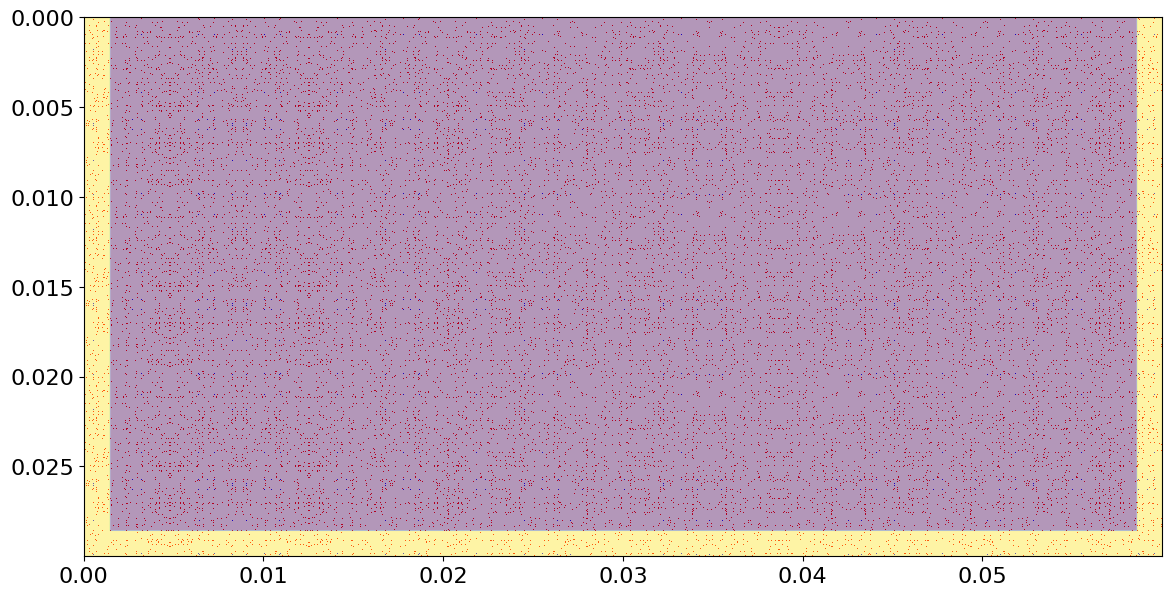

In [26]:
#Used for reshaping
vnx = nx + 2*nb
vnz = nz + 2*nb

# Using params for snapshotting
nsnaps = 133            # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=2,
                     save=nsnaps, time_dim=time_subsampled)

op_snapshot = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term, subs=model.spacing_map)  # operator with snapshots
# Run the operator for `(nt-2)` time steps:
op_snapshot(time=nt - 2, dt=model.critical_dt)

plot_snapshot_and_signal(usave.data, model, f'{alpha}.gif')

### 1 RickerSource

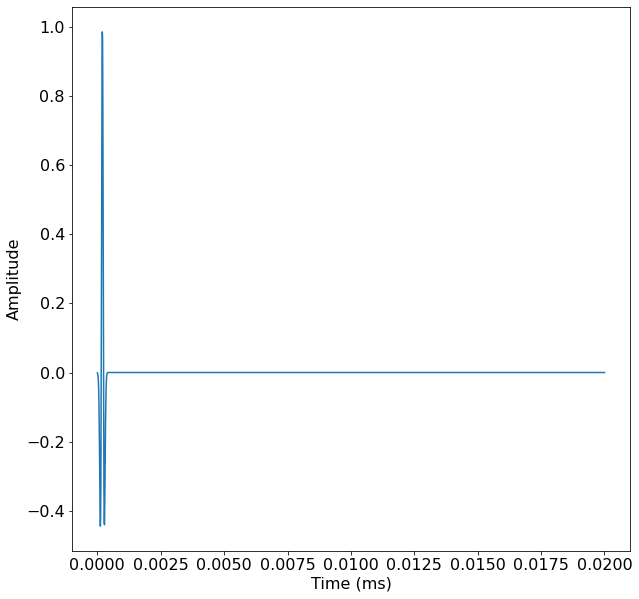

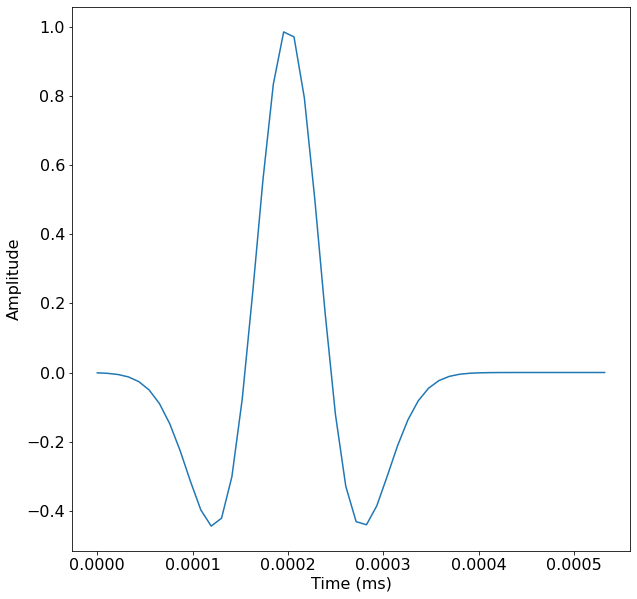

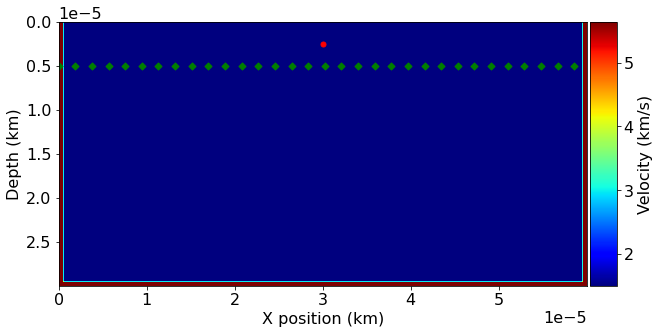

Operator `Kernel` ran in 0.64 s


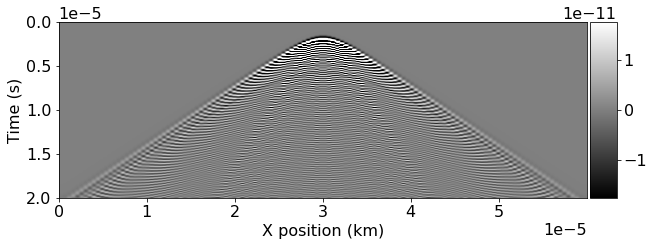

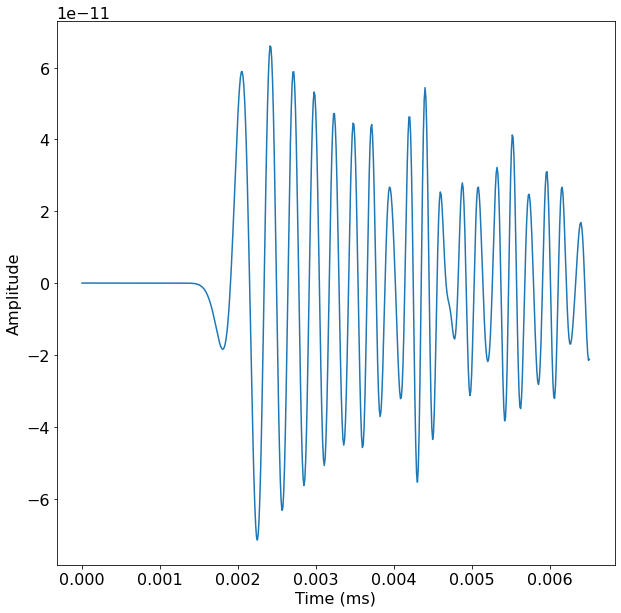

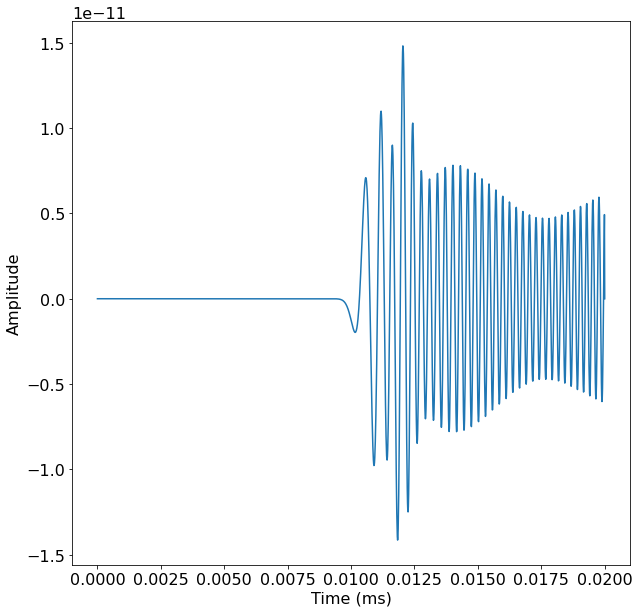

In [4]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 1; # number of sources
nr = 128; # number of receivers
depth = .0025
wavelength = v_water / f0
source_distance = 500 * wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:50], src.data[:50,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:] = pos[:]
src.coordinates.data[:, -1] = depth

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .005

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values[:600],rec.data[:600,64])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plt.figure()
plt.plot(src.time_values,rec.data[:,32])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()
    

### 1 SineSource

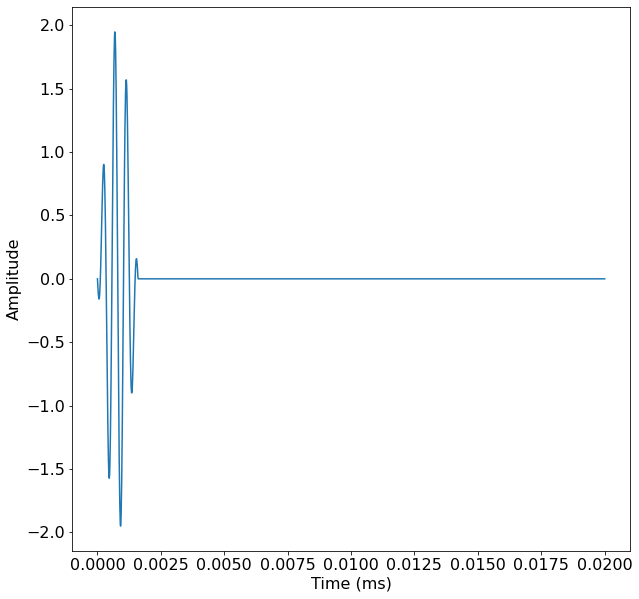

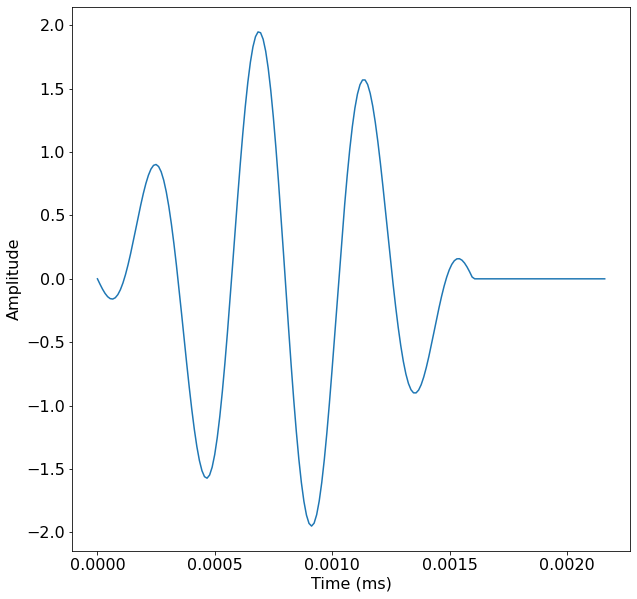

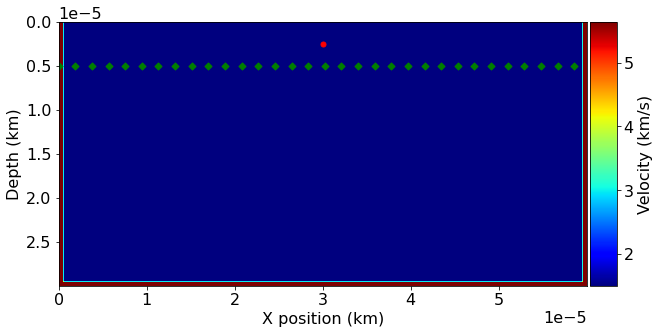

Operator `Kernel` ran in 0.54 s


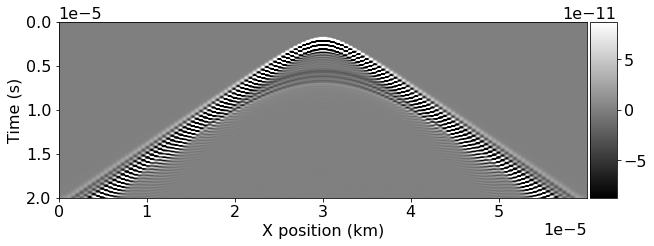

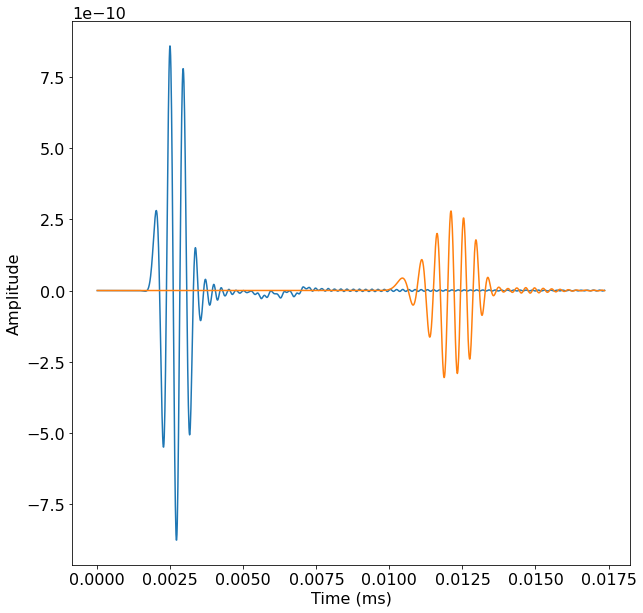

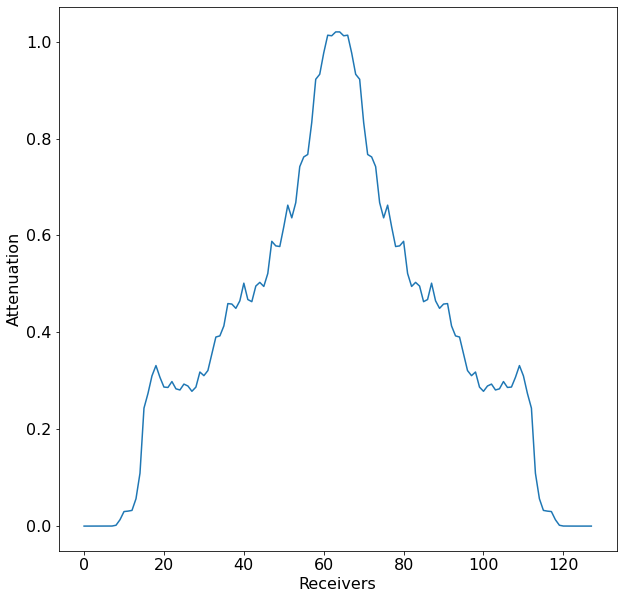

In [5]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 1; # number of sources
nr = 128; # number of receivers
depth = .0025
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = 500 * wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:200], src.data[:200,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:] = pos[:]
src.coordinates.data[:, -1] = depth

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .005

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values[:1600],rec.data[:1600,64])
plt.plot(src.time_values[:1600],rec.data[:1600,32])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plt.figure()
plt.plot(np.max(np.abs(rec.data[0:1600,:]), axis=0)/np.max(rec.data[0:1600,64]))
plt.xlabel('Receivers')
plt.ylabel('Attenuation')
plt.tick_params()
plt.show()

### 2 SineSource

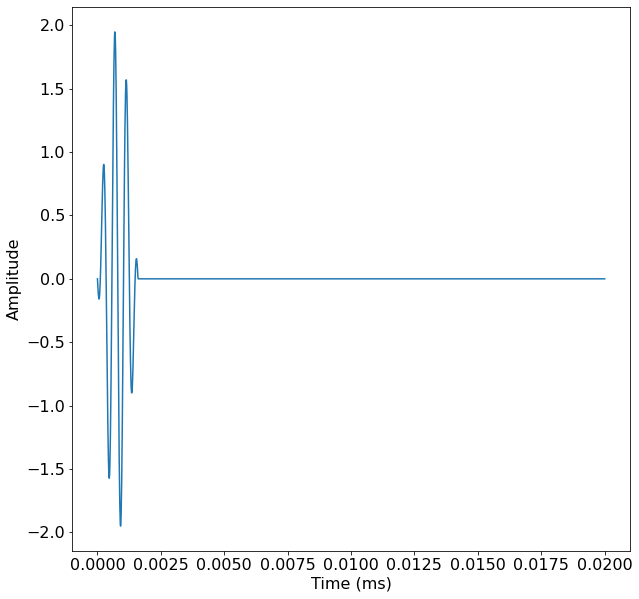

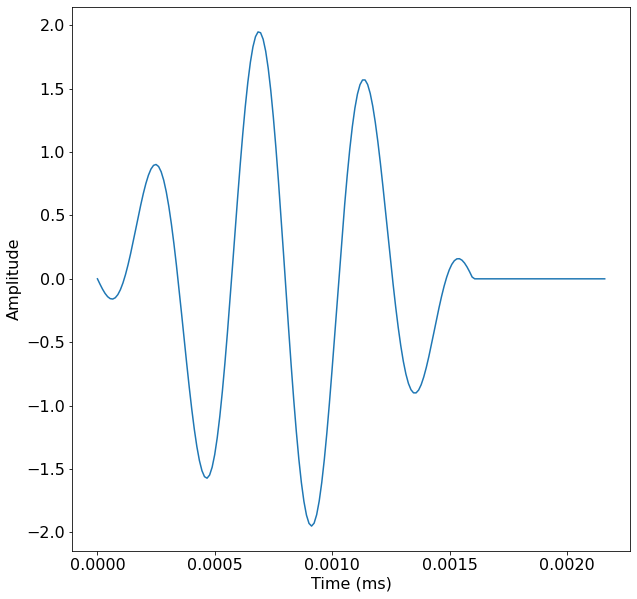

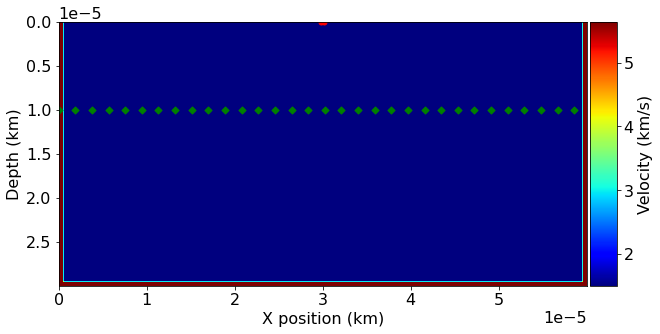

Operator `Kernel` ran in 0.49 s


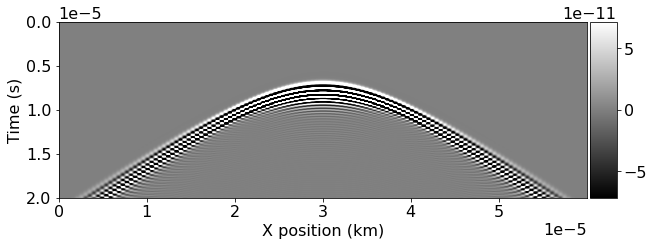

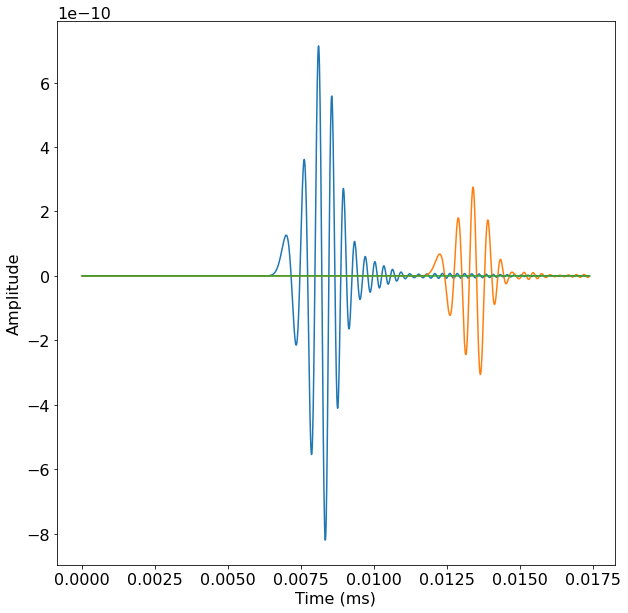

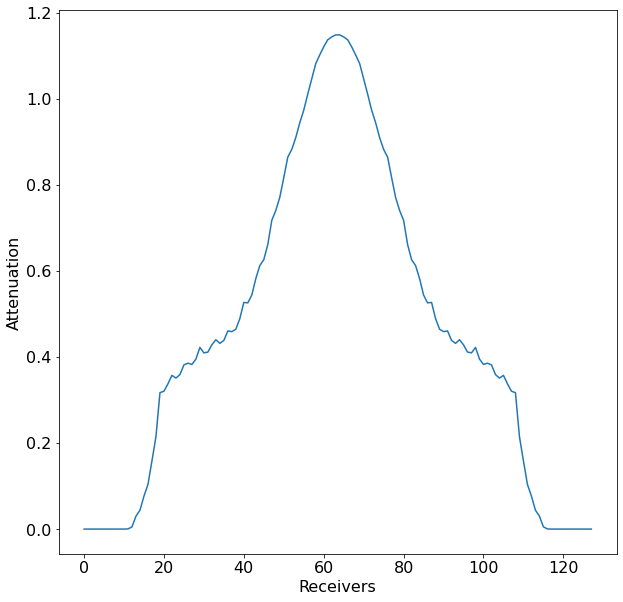

In [6]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 2; # number of sources
nr = 128; # number of receivers
depth = .0005
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:200], src.data[:200,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:, -1] = depth
src.coordinates.data[:] = pos[:]

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .01

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

cut = 1600

plt.figure()
plt.plot(src.time_values[:cut],rec.data[:cut,64])
plt.plot(src.time_values[:cut],rec.data[:cut,32])
plt.plot(src.time_values[:cut],rec.data[:cut,1])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plt.figure()
plt.plot(np.max(np.abs(rec.data[0:cut,:]), axis=0)/np.max(rec.data[0:cut,int(nr/2)]))
plt.xlabel('Receivers')
plt.ylabel('Attenuation')
plt.tick_params()
plt.show()

### 4 SineSource

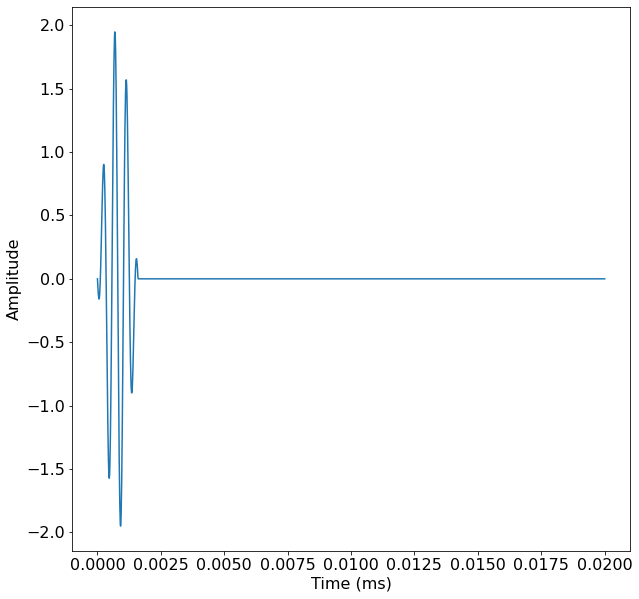

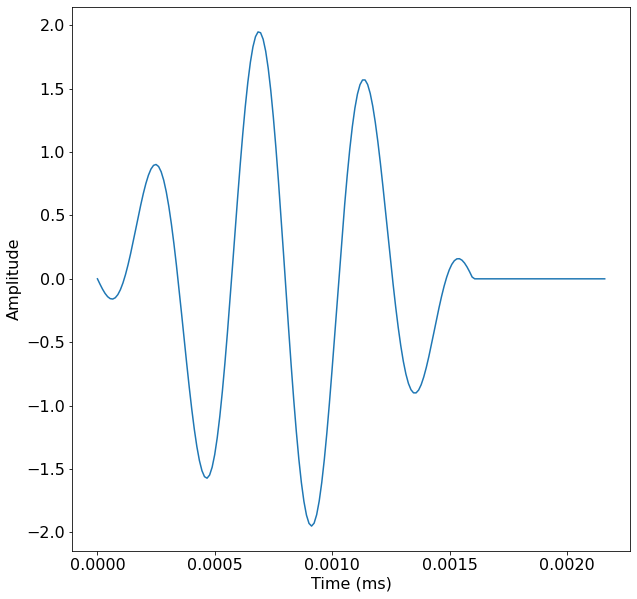

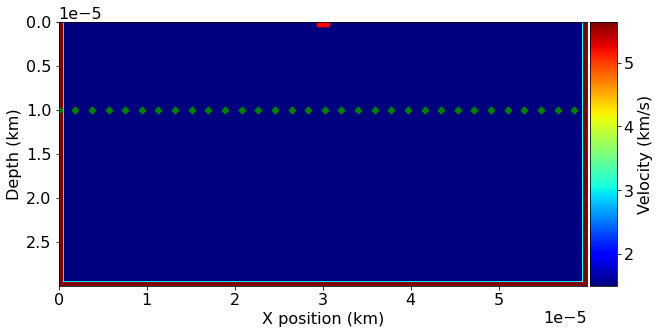

Operator `Kernel` ran in 0.61 s


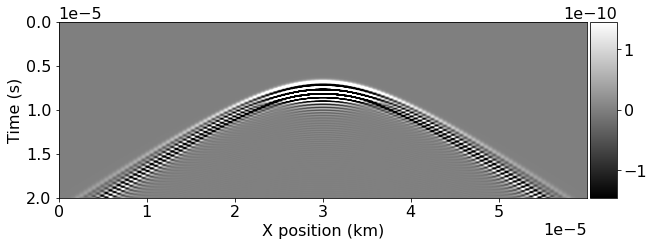

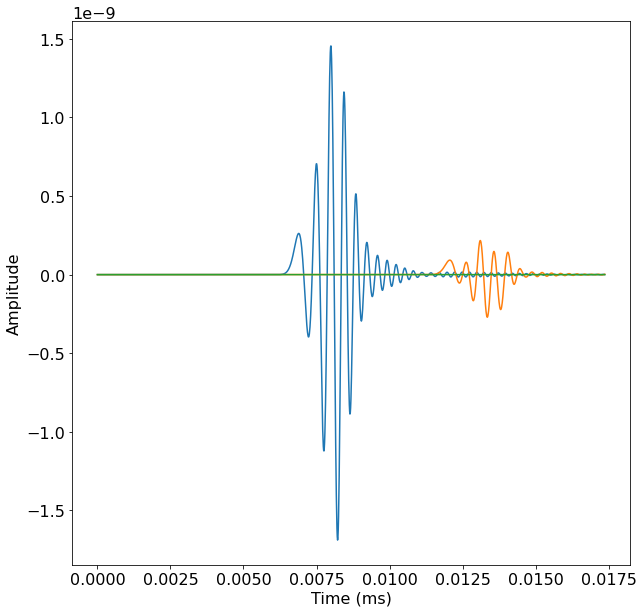

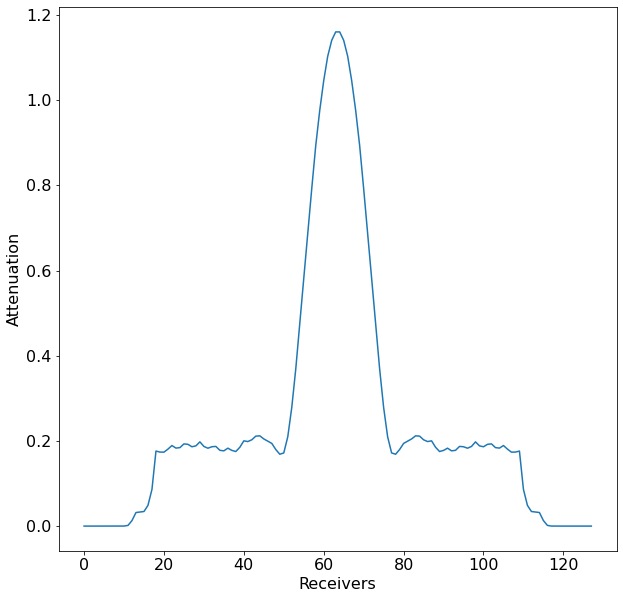

In [7]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 4; # number of sources
nr = 128; # number of receivers
depth = .0005
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:200], src.data[:200,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:, -1] = depth
src.coordinates.data[:] = pos[:]

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .01

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

cut = 1600

plt.figure()
plt.plot(src.time_values[:cut],rec.data[:cut,64])
plt.plot(src.time_values[:cut],rec.data[:cut,32])
plt.plot(src.time_values[:cut],rec.data[:cut,1])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plt.figure()
plt.plot(np.max(np.abs(rec.data[0:cut,:]), axis=0)/np.max(rec.data[0:cut,int(nr/2)]))
plt.xlabel('Receivers')
plt.ylabel('Attenuation')
plt.tick_params()
plt.show()

### 10 SineSource

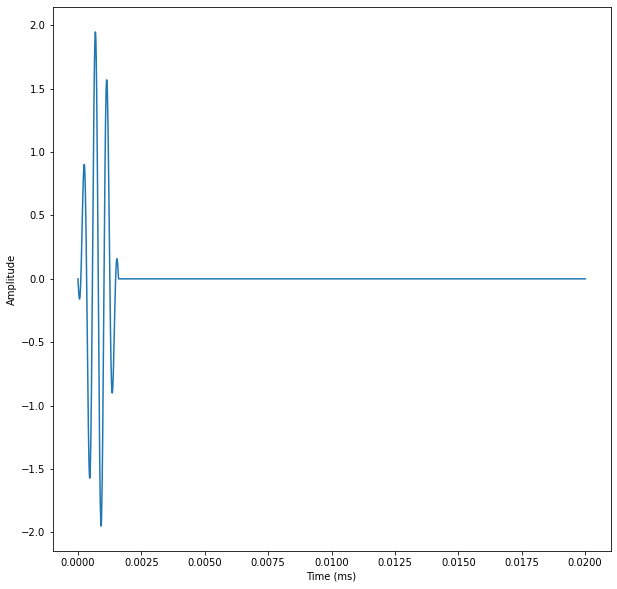

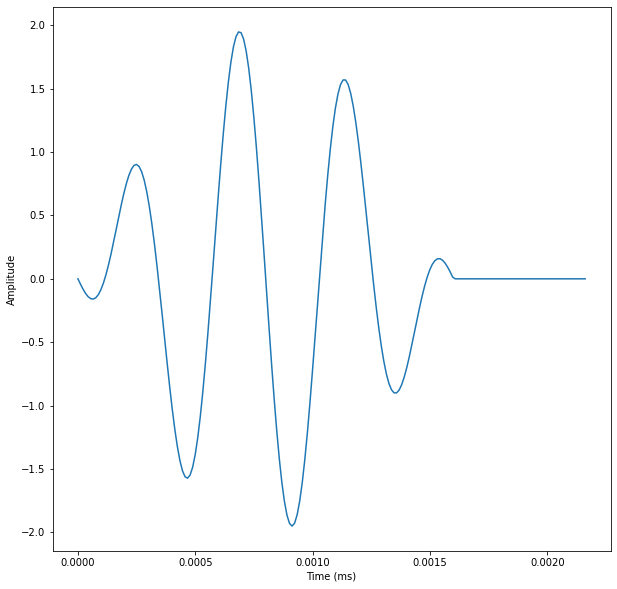

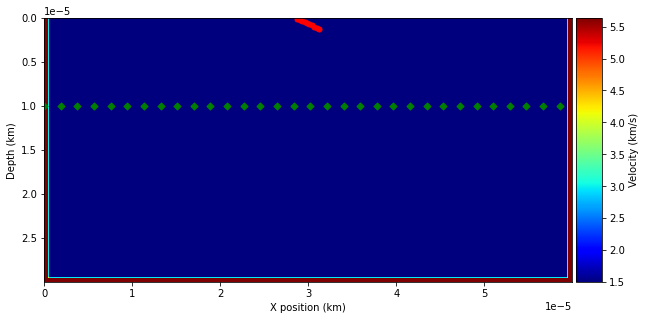

Operator `Kernel` ran in 0.32 s


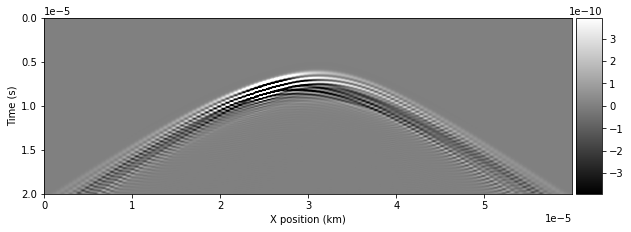

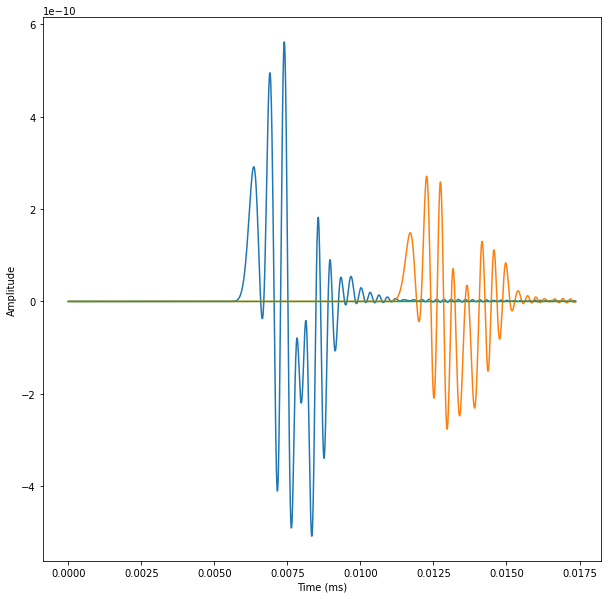

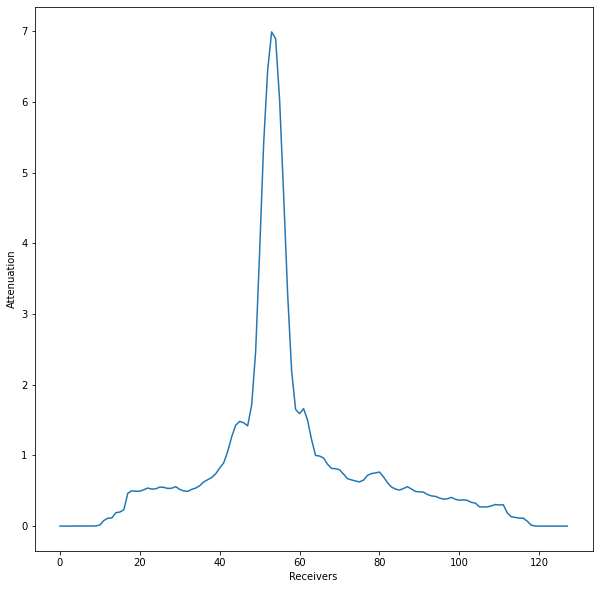

In [28]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 10; # number of sources
nr = 128; # number of receivers
depth = .0005
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = wavelength
alpha = 65 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:200], src.data[:200,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:, -1] = depth
src.coordinates.data[:] = pos[:]

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .01

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

cut = 1600

plt.figure()
plt.plot(src.time_values[:cut],rec.data[:cut,64])
plt.plot(src.time_values[:cut],rec.data[:cut,32])
plt.plot(src.time_values[:cut],rec.data[:cut,1])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plt.figure()
plt.plot(np.max(np.abs(rec.data[0:cut,:]), axis=0)/np.max(rec.data[0:cut,int(nr/2)]))
plt.xlabel('Receivers')
plt.ylabel('Attenuation')
plt.tick_params()
plt.show()